In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import neighbors
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

Let's start by importing our data and performing additional processing.

In [2]:
hospPredictions = np.genfromtxt('combined1.csv', delimiter=',', skip_header=True, usecols = (125))
features = np.genfromtxt('combined1.csv', delimiter=',', skip_header=True, usecols = (range(123)))[:, 2:]
regions = np.genfromtxt('combined1.csv', delimiter=',', skip_header=True, usecols = (0), dtype = 'str')
dates = np.genfromtxt('combined1.csv', delimiter=',', skip_header=True, usecols = (1), dtype = 'datetime64')

# additional cleaning, this is clarified in the additional split later down
droppedRegions = np.array((regions == "US-AK", regions == "US-DC", regions == "US-DE", regions == "US-NE", regions == "US-VT", regions == "US-WV"))
droppedRegionsIndices = np.argwhere(np.logical_or.reduce(droppedRegions))[:,0]

dates = np.delete(dates, droppedRegionsIndices, axis = 0)
features = np.delete(features, droppedRegionsIndices, axis = 0)
regions = np.delete(regions, droppedRegionsIndices, axis = 0)
hospPredictions = np.delete(hospPredictions, droppedRegionsIndices, axis = 0)

# based on initial testing, it was decided that the data required more cleaning so we drop highly correlated features
# source: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

df = pd.DataFrame(features)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
df = df.drop(df[to_drop], axis=1)
features = df.to_numpy()

We'll also get some commonly used helpers out of the way.

This includes a method to calculate the KNN and return the mean squared error. The same is done for decision trees.

In [3]:
def knn(xTrain, yTrain, xValidation, yValidation, k = 5):
    """Performns a train-validation run of KNN and returns the mean squared error

    Keyword arguments:
    xTrain -- the features to train on
    yTrain -- the result to train on
    xValidation -- the features to validate with
    yValidation -- the expected validation results
    k -- the number of neighbors
    """
    knn = neighbors.KNeighborsRegressor(n_neighbors = k)
    knn.fit(xTrain, yTrain)
    prediction = knn.predict(xValidation)
    return mean_squared_error(yValidation, prediction)

def decisionTree(xTrain, yTrain, xValidation, yValidation, depth):
    """Performns decision tree regression and returns the mean squared error

    Keyword arguments:
    xTrain -- the features to train on
    yTrain -- the result to train on
    xValidation -- the features to validate with
    yValidation -- the expected validation results
    k -- the max-depth of the decision tree
    """
    clf = tree.DecisionTreeRegressor(max_depth = depth, random_state=0)
    clf = clf.fit(xTrain, yTrain)
    prediction = clf.predict(xValidation)
    return mean_squared_error(yValidation, prediction)

With that out of the way, we can begin by splitting data based on the time. The selected time for the split is '2020-08-10'. Any dates after this will be in the test set and the rest of the data will be used for training. We will then test it with KNN/Decision trees.

In all experiments below, are metric of choice is the mean squared error. We also display the root mean squared error in order to make things more human-interpetable.

In [4]:
# neighbors to consider for KNN
K_list = range(1,36)

# get the indices for train/test data
trainIndicesDate = np.argwhere(dates > np.datetime64("2020-08-10"))[:,0]
testIndicesDate = np.argwhere(dates <= np.datetime64("2020-08-10"))[:,0]

# prep the dataset
xTrain = np.take(features, trainIndicesDate, axis = 0)
xValidation = np.take(features, testIndicesDate, axis = 0)
yTrain = np.take(hospPredictions, trainIndicesDate, axis = 0)
yValidation = np.take(hospPredictions, testIndicesDate, axis = 0)

# KNN - This was used to determine the number of neighbours
bestK, bestDepth = -1, -1
bestErrorKnn, bestErrorTree = sys.maxsize, sys.maxsize

for i in K_list:
    newErrorKnn = knn(xTrain, yTrain, xValidation, yValidation, i)
    newErrorTree = decisionTree(xTrain, yTrain, xValidation, yValidation, i)

    if (newErrorKnn < bestErrorKnn):
        bestErrorKnn = newErrorKnn
        bestK = i
    if (newErrorTree < bestErrorTree):
        bestErrorTree = newErrorTree
        bestDepth = i

print("KNN with K = %2d | Decision tree with max depth: %2d" % (bestK, bestDepth))
print("MSE  (KNN):          %7.1f" % (bestErrorKnn))
print("RMSE (KNN):          %7.1f" % (np.sqrt(bestErrorKnn)))
print("MSE (DecisionTree):  %7.1f" % (bestErrorTree))
print("RMSE (DecisionTree): %7.1f" % (np.sqrt(bestErrorTree)))

KNN with K =  7 | Decision tree with max depth:  1
MSE  (KNN):             17.6
RMSE (KNN):              4.2
MSE (DecisionTree):     23.8
RMSE (DecisionTree):     4.9


We can now move onto a split by region.

We first want to select an optimal number of neighbours for k. We will do this by estimating all values of k for each fold, and then select the optimal on average.  We'll do the same for the max depth of the tree although this will be mostly redundant with our range for our dataset.

Optimal number of neighbors at K = 9
Mean MSE  (KNN):             14.1
Mean RMSE (KNN):              3.5



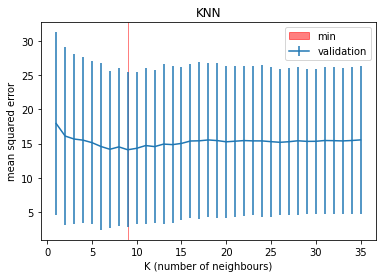

 
Optimal max depth 2
Mean MSE  (Decision Tree):    15.6
Mean RMSE (Decision Tree):     3.7



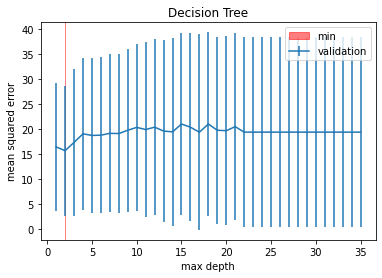

In [5]:
validation_mse_knn = np.zeros((len(K_list), 5))
validation_mse_tree = np.zeros((len(K_list), 5))

for (i, K) in enumerate(K_list):
    gkf = GroupKFold(n_splits=5)
    for (foldNumber, (train_idx, test_idx)) in enumerate(gkf.split(features, hospPredictions, regions)):
        xTrain = np.take(features, train_idx, axis=0)
        xValidation = np.take(features, test_idx, axis=0)
        yTrain = np.take(hospPredictions, train_idx, axis=0)
        yValidation = np.take(hospPredictions, test_idx, axis=0)

        validation_mse_knn[i, foldNumber] = knn(xTrain, yTrain, xValidation, yValidation, K)
        validation_mse_tree[i, foldNumber] = decisionTree(xTrain, yTrain, xValidation, yValidation, K)

mseMeans = np.mean(validation_mse_knn, axis=1)
rmseMeans = np.mean(np.sqrt(validation_mse_knn), axis = 1)
errorIndex = np.where(mseMeans == np.min(mseMeans))[0]
bestK = errorIndex + 1

print("Optimal number of neighbors at K = %d" % (bestK))
print("Mean MSE  (KNN):          %7.1f" % ((mseMeans[errorIndex])))
print("Mean RMSE (KNN):          %7.1f\n" % ((rmseMeans[errorIndex])))

plt.errorbar(K_list, mseMeans, np.std(validation_mse_knn, axis=1), label='validation')
plt.axvspan(bestK, bestK, color='red', alpha=0.5, label = 'min')
plt.legend()
plt.title('KNN')
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

mseMeans = np.mean(validation_mse_tree, axis=1)
rmseMeans = np.mean(np.sqrt(validation_mse_tree), axis = 1)
errorIndex = np.where(mseMeans == np.min(mseMeans))[0]
bestDepth = errorIndex + 1

print(" ")
print("Optimal max depth %d" % (bestDepth))
print("Mean MSE  (Decision Tree): %7.1f" % ((mseMeans[errorIndex])))
print("Mean RMSE (Decision Tree): %7.1f\n" % ((rmseMeans[errorIndex])))

plt.errorbar(K_list, mseMeans, np.std(validation_mse_tree, axis=1), label='validation')
plt.axvspan(bestDepth, bestDepth, color='red', alpha=0.5, label = 'min')
plt.legend()
plt.title('Decision Tree')
plt.xlabel('max depth')
plt.ylabel('mean squared error')
plt.show()

For additional testing, we will first model each region separately.

Once again, we will use both KNNs and decision trees.

This section allowed for additional fine tuning in data cleaning. In addition to our original cleaning method, it highlighted "trouble making" regions (or simply regions we may have missed). This is particularly important for the k-fold region split as not cutting regions to led to more biased results. In fact, this improved the mean squared error by up to 10x and by 4x on average.

In [6]:
K_list = range(1,33)
combined = np.vstack((regions,features.T, hospPredictions)).T
regionSplit = np.split(combined[:, :], np.cumsum(np.unique(combined[:, 0], return_counts=True)[1])[:-1]) # create a list of arrays that contains the features/predictions for a specific region

for regionalData in regionSplit:
    currentRegion = regionalData[0,0] # extract the current region we're predicting
    x = regionalData[:, 1:-1].astype(np.float) # features for the specific region
    y = regionalData[:,-1].astype(np.float) # predictions for each instance of that region

    # here, we will do a simple KNN (k=12) with an 80-20 split
    # this case is a bit more complex to select an optimal number of neighbours so it was manually tuned
    xTrain, xValidation, yTrain, yValidation = train_test_split(x, y, train_size = 0.8, random_state = 0)
    bestK, bestDepth = -1, -1
    bestErrorKnn, bestErrorTree = sys.maxsize, sys.maxsize

    for i in K_list:
        newErrorKnn = knn(xTrain, yTrain, xValidation, yValidation, i)
        newErrorTree = decisionTree(xTrain, yTrain, xValidation, yValidation, i)

        if (newErrorKnn < bestErrorKnn):
            bestErrorKnn = newErrorKnn
            bestK = i
        if (newErrorTree < bestErrorTree):
            bestErrorTree = newErrorTree
            bestDepth = i

    print("Region: %s | MSE (KNN, K = %2d): %7.1f | MSE (DecisionTree, depth = %2d): %7.1f" % (currentRegion, bestK, bestErrorKnn, bestDepth, bestErrorTree))

Region: US-HI | MSE (KNN, K =  5):     0.5 | MSE (DecisionTree, depth =  7):     0.3
Region: US-ID | MSE (KNN, K =  7):     4.7 | MSE (DecisionTree, depth =  3):     4.8
Region: US-ME | MSE (KNN, K = 11):     0.6 | MSE (DecisionTree, depth =  4):     2.9
Region: US-MT | MSE (KNN, K =  2):     1.5 | MSE (DecisionTree, depth =  2):     1.1
Region: US-ND | MSE (KNN, K =  1):     0.8 | MSE (DecisionTree, depth =  1):    10.1
Region: US-NH | MSE (KNN, K = 23):     4.8 | MSE (DecisionTree, depth =  8):     4.1
Region: US-NM | MSE (KNN, K =  3):    27.7 | MSE (DecisionTree, depth =  5):    28.1
Region: US-RI | MSE (KNN, K =  2):    13.6 | MSE (DecisionTree, depth =  6):    52.4
Region: US-SD | MSE (KNN, K =  2):     0.8 | MSE (DecisionTree, depth =  1):     3.6
Region: US-WY | MSE (KNN, K =  8):     0.9 | MSE (DecisionTree, depth =  1):     0.6


As a final test, we will split test and train data by season. 

We will classify dates into
- Winter (this is essentially garbage data in terms of regression, as no hospitalizations were reported here)
- Fall
- Spring
- Summer

We will then test on each season separately. The primary reasoning here is that COVID cases dropped during the summer and began increasing again towards the end of the summer. This can make data difficult to predict if we treat all dates equally as the overall circumstances are not the same.

Within each seasonal grouping, we will do a simple 80-20 data split.

In [7]:
# get the indices for datapoints within each season
summerIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-06-01'), dates <= np.datetime64('2020-08-31')))[:,0]
fallIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-08-01'), dates <= np.datetime64('2020-11-30')))[:,0]
springIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2020-03-01'), dates <= np.datetime64('2020-05-31')))[:,0]
winterIndices = np.argwhere(np.logical_and(dates >= np.datetime64('2019-12-01'), dates <= np.datetime64('2020-02-28')))[:,0]
seasonLabels = ["Winter", "Spring", "Summer", "Fall"]

seasonIndexArray = np.array((winterIndices, springIndices, summerIndices, fallIndices))

for index, seasonIndices in enumerate(seasonIndexArray): 
    x = np.take(features, seasonIndices, axis = 0)
    y = np.take(hospPredictions, seasonIndices, axis = 0)
    
    xTrain, xValidation, yTrain, yValidation = train_test_split(x, y, train_size = 0.8, random_state = 0)
    bestK, bestDepth = -1, -1
    bestErrorKnn, bestErrorTree = sys.maxsize, sys.maxsize

    for i in K_list:
        newErrorKnn = knn(xTrain, yTrain, xValidation, yValidation, i)
        newErrorTree = decisionTree(xTrain, yTrain, xValidation, yValidation, i)

        if (newErrorKnn < bestErrorKnn):
            bestErrorKnn = newErrorKnn
            bestK = i
        if (newErrorTree < bestErrorTree):
            bestErrorTree = newErrorTree
            bestDepth = i

    print("Season: %6s | MSE (KNN, K = %2d): %7.1f | MSE (DecisionTree, depth = %2d): %7.1f" % (seasonLabels[index], bestK, bestErrorKnn, bestDepth, bestErrorTree))


Season: Winter | MSE (KNN, K =  1):     0.0 | MSE (DecisionTree, depth =  1):     0.0
Season: Spring | MSE (KNN, K =  4):    41.7 | MSE (DecisionTree, depth =  2):    41.5
Season: Summer | MSE (KNN, K =  3):     5.0 | MSE (DecisionTree, depth =  9):     4.6
Season:   Fall | MSE (KNN, K =  6):    10.4 | MSE (DecisionTree, depth =  3):     9.2
